# Investigating the DNN based electron ID

This study uses a flattened ntuple containing the DNN scores for individual electrons (along with other variables which I am ignoring for now). The input files from which these flat ntuples are produced are MiniAOD samples.

The DNN-ID for the electrons is based on the following scores of a multiclassifier.
```
'dnn_signal_Isolated'
'dnn_signal_nonIsolated'
'dnn_bkg_nonIsolated'
'dnn_bkg_Tau'
'dnn_bkg_Photon'
```
The MVA scores used in this study are the following.
```
'Fall17IsoV2Vals'
'Fall17IsoV2RawVals'
'RunIIIWinter22IsoV1Vals' *in case of Run3Winter23*
'RunIIIWinter22IsoV1RawVals' *in case of Run3Winter23*
```
These variables in the ntuple are produced using the following script. This ntuple maker runs in a CMSSW_13_0_8 environment which has the new RunIII MVA scores.

**ntuple maker:** <a href="https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/test/testElectronMVA_cfg.py">GitHub: cmssw/RecoEgamma/ElectronIdentification/test
/testElectronMVA_cfg.py</a><br>
(`testElectronMVARun3_cfg.py` in case of Run3Winter23)

The goal of this study is to compare these scores with the MVA scores.

---

# Setting up ...
The following cell contains all the global settings (like campaign name, branches, input and output directories etc.) The rest of the cells need not be modified.

In [1]:
import os, sys
import uproot
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import collections #for sorting dictionaries
from custom_func import *

########################
# INPUTS AND OUTPUTS
########################
campaign = 'Run3Summer22'
indir = 'inputs/'+campaign
outdir = 'plots/'+campaign
os.makedirs(outdir, exist_ok=True)

balanceSigBkg = False #This randomly drops rows to balance nsig and nbkg

########################
#LISTS AND DICTIONARIES
########################
branches = [
    'ele_pt', 'ele_eta',
    'matchedToGenEle', #flag for deciding whether it is a signal or background electron 
    'dnn_signal_Isolated', 'dnn_signal_nonIsolated', 'dnn_bkg_nonIsolated', 'dnn_bkg_Tau', 'dnn_bkg_Photon', #DNN scores
    'Fall17IsoV2Vals', 'Fall17IsoV2RawVals', #MVA IDs from Run2
    #'RunIIIWinter22IsoV1Vals', 'RunIIIWinter22IsoV1RawVals' #MVA IDs from Run3
]

#DNN scores which are considered in plotting:
vardnn = ['score1', 'score2', 'score3', 'score4', 'score5']
#MVA scores which are considered in plotting:
varmva = ['MVA1', 'MVA2']

#renaming columns for my convenience:
rename = {
    'dnn_signal_Isolated':'score1',
    'dnn_signal_nonIsolated':'score2',
    'dnn_bkg_nonIsolated':'score3',
    'dnn_bkg_Tau':'score4',
    'dnn_bkg_Photon':'score5',
    'matchedToGenEle':'genmatch',
    'Fall17IsoV2Vals':'MVA1',
    'Fall17IsoV2RawVals':'MVA2',
    #'RunIIIWinter22IsoV1Vals':'MVA3',
    #'RunIIIWinter22IsoV1RawVals':'MVA4'
}

#Reversing this dictionary for later use
alias = {value: key for key, value in rename.items()}

sampledict = {
    "dy":{"name":"DrellYan", "color":"seagreen"},
    "qcd":{"name":"QCD", "color":"dodgerblue"},
    "gjet":{"name":"Gamma Jet", "color":"mediumorchid"},
    "taugun":{"name":"TauGun", "color":"orangered"},
}

print('Packages and functions loaded.')

Packages and functions loaded.


##### Reading input files

In [2]:
df = pd.DataFrame()

for name, val in sampledict.items():
    for filename in os.listdir(indir):
        if filename.startswith('ntuple_'+campaign+'_'+name):
            print(f'Reading file: {filename}')
            file=uproot.open(indir+'/'+filename)
            tree=file['ntuplizer/tree']
            df_temp=make_df(tree,branches,name)
            df=pd.concat([df, df_temp])
            
print('Reading successful!')
df[['ele_pt', 'ele_eta', 'matchedToGenEle', 'dnn_signal_Isolated', 'sample']]

Reading file: ntuple_Run3Summer22_dy.root
Reading file: ntuple_Run3Summer22_qcd.root
Reading file: ntuple_Run3Summer22_gjet.root
Reading file: ntuple_Run3Summer22_taugun.root
Reading successful!


,ele_pt,ele_eta,matchedToGenEle,dnn_signal_Isolated,sample
0,5.495893,2.044591,0,0.096490,dy
1,10.369920,-0.342826,2,0.675292,dy
2,9.652797,-1.871975,0,0.084962,dy
3,5.465273,-1.018275,3,0.400029,dy
4,12.036389,-2.063322,0,0.001662,dy
...,...,...,...,...,...
171106,13.619144,-1.004480,0,0.005307,taugun
171107,6.513440,-2.355769,0,0.025440,taugun
171108,25.561138,-0.215494,0,0.000068,taugun
171109,8.610294,0.143899,0,0.248473,taugun


##### Managing the dataframe and defining signal/background

The variable, `matchedToGenEle` contains integers, which mean the following things:

- 0: The candidate does not match to any gen-electron. (fake)
- 1: The candidate is a prompt, real electron; matches to gen-electron.
- 2: The candidate is a prompt, gen-matched electron decaying from a tau (not part of a jet).
- 3: The candidate is a real electron, but not isolated.

The signal electrons have `matchedToGenEle == 1 OR 2`<br>
The backgrounds have `matchedToGenEle == 0 OR 3`

In [3]:
df.rename(columns = rename, inplace = True)

#Normalizing all the scores from 0 to 1
for score, name in  rename.items():
    if score.startswith('dnn') or score=='matchedToGenEle' : break
    df=normalize_col(df, name)

#################################
# DEFINING SIGNAL AND BACKGROUND
#################################
sig_flag = (df['genmatch'] == 1) | (df['genmatch'] == 2)
bkg_flag = (df['genmatch'] == 0) | (df['genmatch'] == 3)

df.loc[sig_flag, 'truth'] = 1
df.loc[bkg_flag, 'truth'] = 0

#Randomizing rows:
df = df.sample(frac=1) #randomizing rows
df.reset_index(inplace=True, drop=True)

if balanceSigBkg == True:
    #randomly dropping backgrounds:
    ndelete = 300000
    if df[df['truth'] == 0].shape[0] > ndelete :
        indices = df[df['truth'] == 0].sample(n=ndelete, random_state=42).index
        df = df.drop(indices)  
    #dropping indices again, after removing rows randomly.
    df.reset_index(inplace=True, drop=True)

nsig = df[df['truth']==1].shape[0]
nbkg = df[df['truth']==0].shape[0]

###############
#Printing info:
###############
txtfilepath = f'plots/{campaign}/statistics.txt'
if os.path.exists(txtfilepath): os.remove(txtfilepath)
txtfile = open(txtfilepath, 'a')
for name, val in sampledict.items():
    print_info(df, name, txtfile)

stats = f'Total : sig = {nsig} ({nsig*100/df.shape[0]:.1f}%), bkg = {nbkg} ({nbkg*100/df.shape[0]:.1f}%)'
print(stats)
txtfile.write(stats)
txtfile.close()

df[['genmatch', 'MVA1', 'score1', 'sample', 'truth']]

Sample : dy; 	nCandidates = 76161; nsig = 60098 (78.9%), nbkg = 16063 (21.1%)
Sample : qcd; 	nCandidates = 61627; nsig = 0 (0.0%), nbkg = 61627 (100.0%)
Sample : gjet; 	nCandidates = 111633; nsig = 0 (0.0%), nbkg = 111633 (100.0%)
Sample : taugun; 	nCandidates = 171111; nsig = 0 (0.0%), nbkg = 171111 (100.0%)
Total : sig = 60098 (14.3%), bkg = 360434 (85.7%)


,genmatch,MVA1,score1,sample,truth
0,0,0.994998,0.999999,taugun,0.0
1,0,-0.951721,0.012830,gjet,0.0
2,0,-0.999935,0.007206,taugun,0.0
3,3,0.999999,0.655072,taugun,0.0
4,0,0.971238,0.489970,dy,0.0
...,...,...,...,...,...
420527,1,0.999990,0.980213,dy,1.0
420528,0,0.987730,0.412212,gjet,0.0
420529,0,-0.516667,0.001265,gjet,0.0
420530,1,0.999975,0.815143,dy,1.0


# Investigating the different samples:

Let's look at the following.
1. how the DNN scores look like for signal and background (overlayed)
2. how the DNN scores look like for candidates from different samples (overlayed)
3. how the MVA scores look like for signal and background (overlayed)
4. how the MVA scores look like for candidates from different samples (overlayed)

### DNN scores for signal and background:

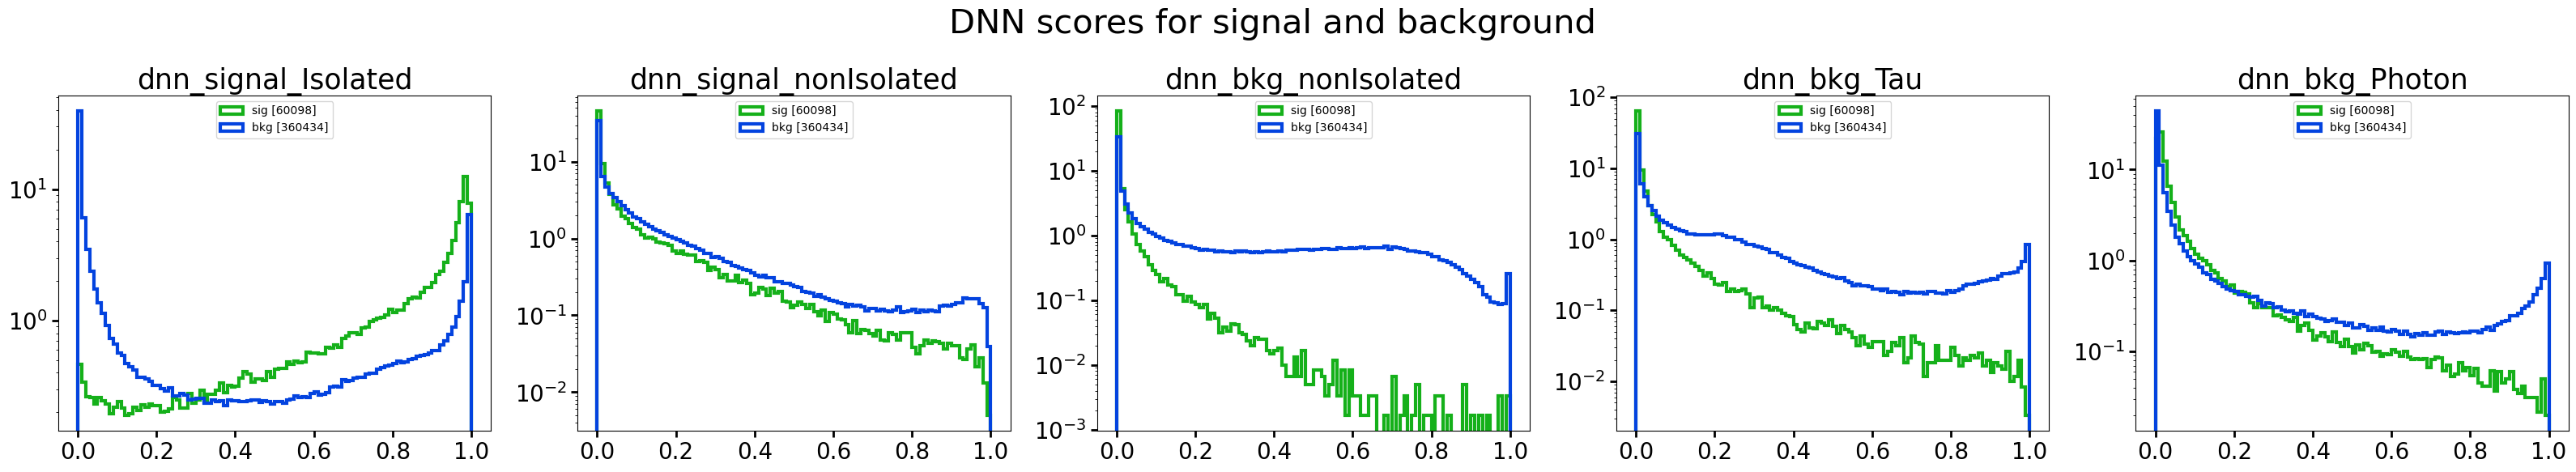

In [4]:
fig1, ax1 = plt.subplots(1,5,figsize=(40,6))
ax1 = ax1.flatten()
fig1.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.8)

bins_=np.arange(0, 1.01, 0.01)
fig1.suptitle('DNN scores for signal and background', fontsize=30) #Global title

nsig = df[df['truth']==1].shape[0]
nbkg = df[df['truth']==0].shape[0]

for i in range(len(vardnn)):
    ax1[i].hist(df[df['truth']==1][vardnn[i]], bins=bins_, histtype='step', linewidth = 3,
                color='xkcd:green',  label=f'sig [{nsig}]', density=True)
    ax1[i].hist(df[df['truth']==0][vardnn[i]], bins=bins_, histtype='step', linewidth = 3,
                color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
    ax1[i].set_title(alias[vardnn[i]], fontsize=25)
    ax1[i].set_yscale('log')
    ax1[i].legend(loc='upper center')
    ax1[i].tick_params(axis='both', labelsize=20, width=2, length=6)
    
plt.savefig(outdir+'/all_dnn_overlayed.png', bbox_inches='tight', dpi=300)
plt.show()

### DNN scores for candidates from different samples:

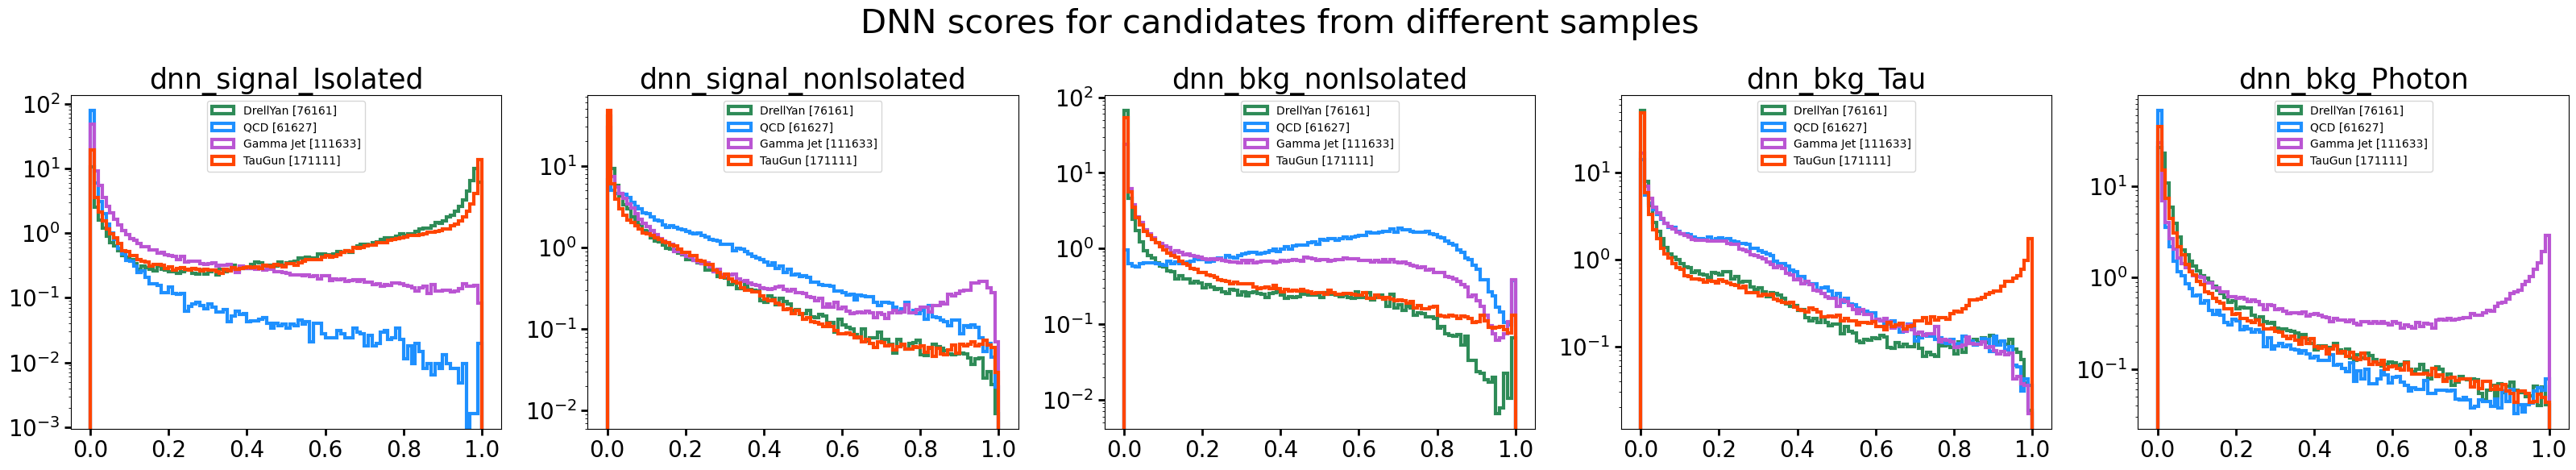

In [5]:
fig2, ax2 = plt.subplots(1,5,figsize=(40,6))
ax2 = ax2.flatten()
fig2.subplots_adjust(hspace=0.3)
plt.subplots_adjust(top=0.8)
fig2.suptitle('DNN scores for candidates from different samples', fontsize=30)
bins_=np.arange(0, 1.01, 0.01)

for i in range(len(vardnn)):
    for sample, val in sampledict.items():
        count = df[df['sample']==sample].shape[0]
        ax2[i].hist(df[df['sample']==sample][vardnn[i]], bins=bins_, histtype='step', linewidth = 3,
                color=val['color'],  label=f'{val["name"]} [{count}]', density=True)
    ax2[i].set_title(alias[vardnn[i]], fontsize=25)
    ax2[i].set_yscale('log')
    ax2[i].legend(loc='upper center')
    ax2[i].tick_params(axis='both', labelsize=20, width=2, length=6)
    
plt.savefig(outdir+'/all_dnn_samples.png', bbox_inches='tight', dpi=300)
plt.show()

# Comapring ROC curves

In [6]:
#ROC calculation:
from sklearn.metrics import roc_curve,auc

true = df['truth'] #Either 0, or 1

ROC_dict ={
    "score1":{},
    "score2":{},
    "score3":{},
    "score4":{},
    "score5":{},
    "MVA1":{},
    "MVA2":{},
}

def find_tpr_fnr_auc(true, pred):
    fpr, tpr, _ = roc_curve(true, pred)
    auc_score   = auc(tpr,1-fpr)
    tpr=tpr*100
    fnr=(1-fpr)*100
    return fnr, tpr, auc_score

for score, scoredict in ROC_dict.items():
    fnr, tpr, auc_score = find_tpr_fnr_auc(true, df[score])
    scoredict["fnr"] = fnr
    scoredict["tpr"] = tpr
    scoredict["auc"] = auc_score
    
#Sorting it according to AUC
import collections
ROC_dict = collections.OrderedDict(sorted(ROC_dict.items(), key=lambda x: x[1]["auc"], reverse=True))

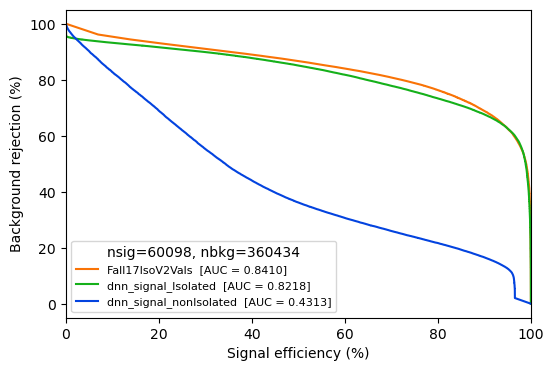

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

#make plots for only the following:
plotdict={
    'dnn_signal_Isolated':'xkcd:green',
    'dnn_signal_nonIsolated':'xkcd:blue',
    #'dnn_bkg_nonIsolated',
    'Fall17IsoV2Vals':'xkcd:orange',
    #'Fall17IsoV2RawVals',
    #'RunIIIWinter22IsoV1Vals':'xkcd:red',
    #'RunIIIWinter22IsoV1RawVals'
}

for score, scoredict in ROC_dict.items():
    for plot, color_ in plotdict.items():
        if(plot == alias[score]):
            tpr = scoredict["tpr"]
            fnr = scoredict["fnr"]
            auc = scoredict["auc"]
            label_ = alias[score]+f'  [AUC = {auc:.4f}]'
            ax.plot(tpr,fnr,color=color_,label=label_)

nsig = df[df['truth']==1].shape[0]
nbkg = df[df['truth']==0].shape[0]
legendheader = f'nsig={nsig}, nbkg={nbkg}'

ax.set_xlabel('Signal efficiency (%)')
ax.set_xlim(0, 100)
#ax3.set_xscale('log')
ax.set_ylabel('Background rejection (%)')
ax.legend(loc='lower left', prop={"size":8}, title=legendheader, fontsize='small')

plt.savefig(f'plots/{campaign}/all_roc.png', bbox_inches='tight', dpi=300)
plt.show()

# Splitting the dataframe into pT-eta bins

Let's plot pT and eta of all the candidates.

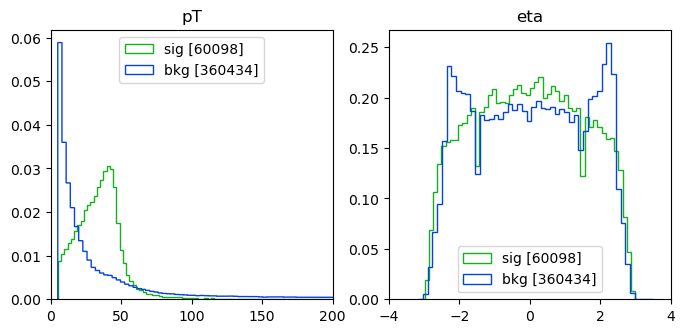

In [8]:
fig3, ax3 = plt.subplots(1,2,figsize=(8,3.5))
ax3 = ax3.flatten()
fig3.subplots_adjust(hspace=0.5)
nptbins =200
netabins=50

nsig=df[df['truth']==1].shape[0]
nbkg=df[df['truth']==0].shape[0]

ax3[0].hist(df[df['truth']==1]['ele_pt'], bins=nptbins, histtype='step',
            color='xkcd:green',  label=f'sig [{nsig}]', density=True)
ax3[0].hist(df[df['truth']==0]['ele_pt'], bins=nptbins*10, histtype='step',
            color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
ax3[0].set_title('pT')
ax3[0].set_xlim(0, nptbins)
#ax6[0].set_yscale('log')
ax3[0].legend(loc='upper center')

ax3[1].hist(df[df['truth']==1]['ele_eta'], bins=netabins, histtype='step',
            color='xkcd:green',  label=f'sig [{nsig}]', density=True)
ax3[1].hist(df[df['truth']==0]['ele_eta'], bins=netabins, histtype='step',
            color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
ax3[1].set_title('eta')
ax3[1].set_xlim(-4, 4)
#ax6[1].set_yscale('log')
ax3[1].legend(loc='lower center')

plt.savefig(f'plots/{campaign}/all_pt-eta.png', bbox_inches='tight', dpi=300)
plt.show()

### Splitting scheme:
Let's split the original dataframe into pT/eta bins.<br>
- For eta bins, I choose barrel (`abs(eta)<1.442`) and endcap (`abs(eta)>1.442`)<br>
- For pT bins, I choose `pt<20`, `20<pt<60` and `pt>60`

In [9]:
df.loc[df['ele_pt'] < 20, 'ptbin'] = 'lowpt'
df.loc[(20 < df['ele_pt']) & (df['ele_pt'] < 60), 'ptbin'] = 'medpt'
df.loc[60 < df['ele_pt'], 'ptbin'] = 'highpt'

df.loc[df['ele_eta'] < 1.442, 'etabin'] = 'barrel'
df.loc[df['ele_eta'] > 1.442, 'etabin'] = 'endcap'

nlowbar = df[(df['ptbin']=='lowpt') & (df['etabin']=='barrel')].shape[0]
nmedbar = df[(df['ptbin']=='medpt') & (df['etabin']=='barrel')].shape[0]
nhigbar = df[(df['ptbin']=='highpt') & (df['etabin']=='barrel')].shape[0]
nlowend = df[(df['ptbin']=='lowpt') & (df['etabin']=='endcap')].shape[0]
nmedend = df[(df['ptbin']=='medpt') & (df['etabin']=='endcap')].shape[0]
nhigend = df[(df['ptbin']=='highpt') & (df['etabin']=='endcap')].shape[0]

df[['ele_pt', 'ele_eta', 'sample', 'truth', 'ptbin', 'etabin']]
print(f'Number of candidates in the pt-eta bins :')

print("pt\tbarrel\tendcap")
print("low\t{}\t{}".format(nlowbar, nlowend))
print("med\t{}\t{}".format(nmedbar, nmedend))
print("high\t{}\t{}".format(nhigbar, nhigend))

Number of candidates in the pt-eta bins :
pt	barrel	endcap
low	139781	42560
med	105445	31746
high	78146	22854


### Plotting DNN and MVA scores in each pt/eta bin

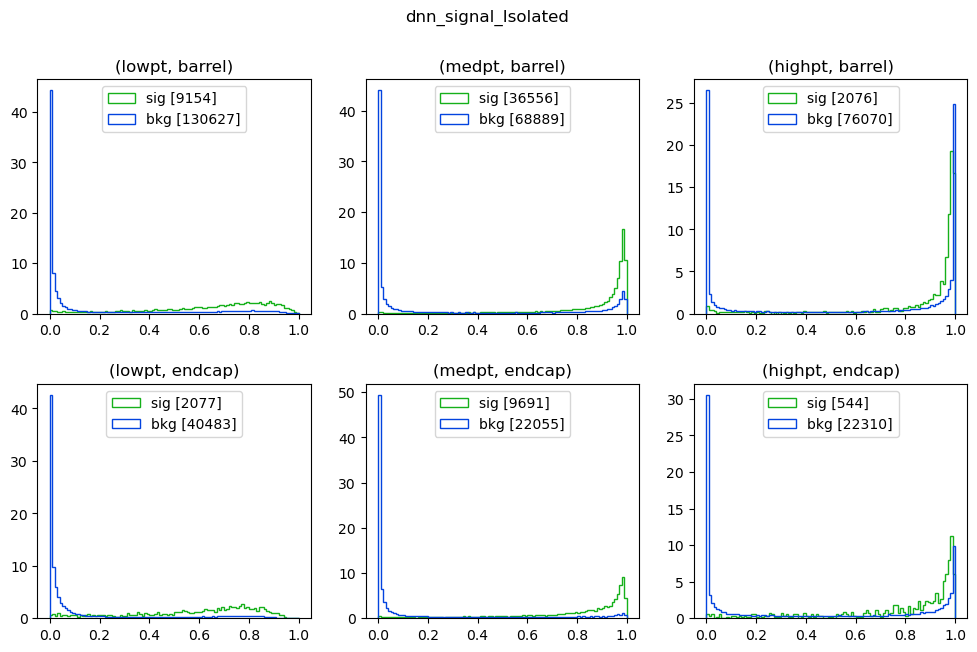

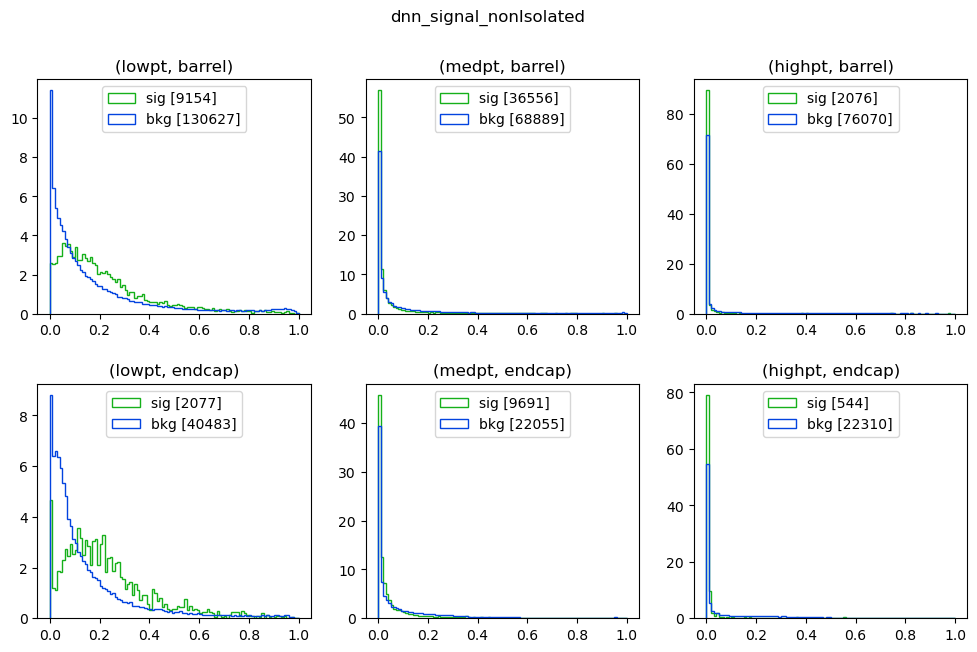

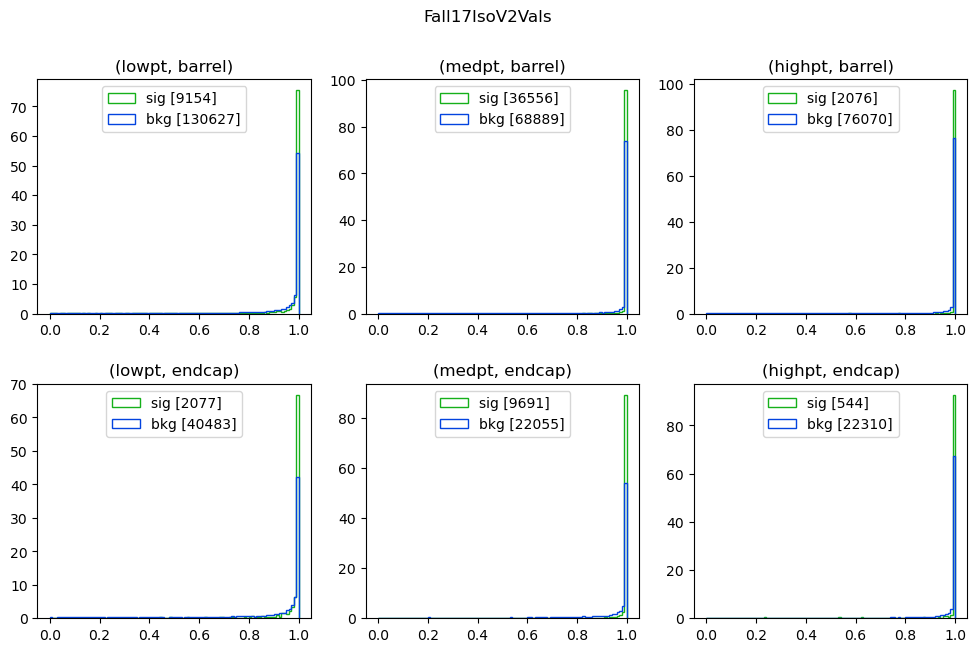

In [10]:
scores = ['score1', 'score2', 'MVA1']
bins_=np.arange(0, 1.01, 0.01)

for score in scores:
    fig4, ax4 = plt.subplots(2,3,figsize=(12,7))
    ax4 = ax4.flatten()
    fig4.subplots_adjust(hspace=0.3)
    fig4.suptitle(alias[score])
    ptbins = ['lowpt', 'medpt', 'highpt']
    
    #Barrel plots:
    for i in [0, 1, 2]:
        sigfilter = (df['truth']==1) & (df['ptbin']==ptbins[i]) & (df['etabin']=='barrel')
        bkgfilter = (df['truth']==0) & (df['ptbin']==ptbins[i]) & (df['etabin']=='barrel')
        nsig_ptetabin = df[sigfilter].shape[0]
        nbkg_ptetabin = df[bkgfilter].shape[0]        
        ax4[i].hist(df[sigfilter][score],bins=bins_, histtype='step', color='xkcd:green',  label=f'sig [{nsig_ptetabin}]', density=True)
        ax4[i].hist(df[bkgfilter][score],bins=bins_, histtype='step', color='xkcd:blue',  label=f'bkg [{nbkg_ptetabin}]', density=True)
        ax4[i].set_title(f'({ptbins[i]}, barrel)')
        #ax4[i].set_yscale('log')
        ax4[i].legend(loc='upper center')
    
    #endcap plots:
    for i in [3, 4, 5]:
        sigfilter = (df['truth']==1) & (df['ptbin']==ptbins[i-3]) & (df['etabin']=='endcap')
        bkgfilter = (df['truth']==0) & (df['ptbin']==ptbins[i-3]) & (df['etabin']=='endcap')
        nsig_ptetabin = df[sigfilter].shape[0]
        nbkg_ptetabin = df[bkgfilter].shape[0]        
        ax4[i].hist(df[sigfilter][score],bins=bins_, histtype='step', color='xkcd:green',  label=f'sig [{nsig_ptetabin}]', density=True)
        ax4[i].hist(df[bkgfilter][score],bins=bins_, histtype='step', color='xkcd:blue',  label=f'bkg [{nbkg_ptetabin}]', density=True)
        ax4[i].set_title(f'({ptbins[i-3]}, endcap)')
        #ax7[i].set_yscale('log')
        ax4[i].legend(loc='upper center')
        
    plt.savefig(f'plots/{campaign}/ptetabins_{score}.png', bbox_inches='tight', dpi=300)
    plt.show()

### Plotting ROCs in each pt/eta bin:

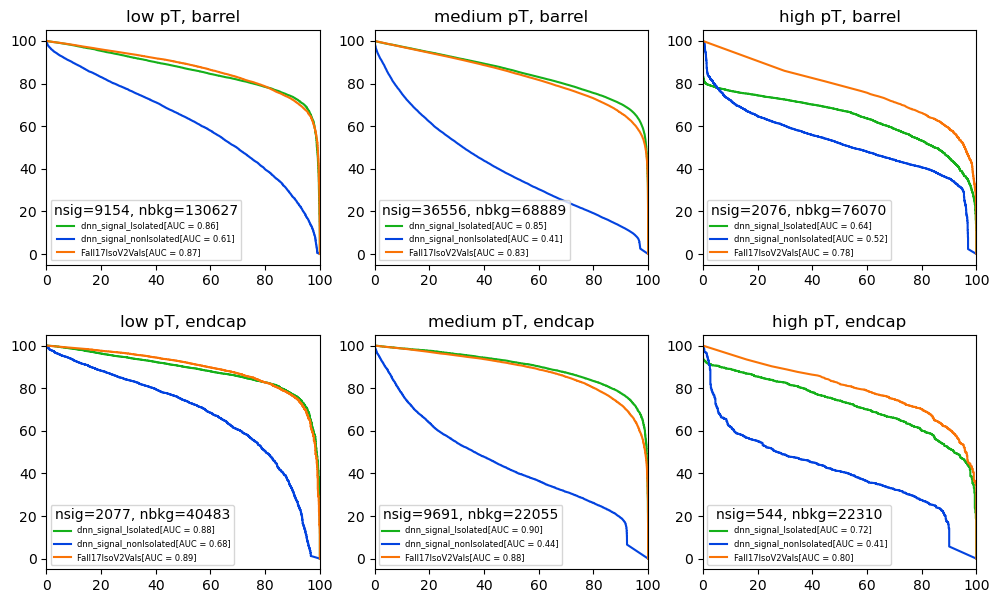

In [11]:
from sklearn.metrics import roc_curve,auc
scores = ['score1', 'score2', 'MVA1']

fig5, ax5 = plt.subplots(2,3,figsize=(12,7))
ax5 = ax5.flatten()
fig5.subplots_adjust(hspace=0.3)
index = 0

#make plots for only the following:
plotdict={
    'dnn_signal_Isolated':'xkcd:green',
    'dnn_signal_nonIsolated':'xkcd:blue',
    'Fall17IsoV2Vals':'xkcd:orange',
    #'RunIIIWinter22IsoV1Vals':'xkcd:red',
}

ptetabins = {
    "low pT, barrel"    :(df['ptbin']=='lowpt') & (df['etabin']=='barrel'),
    "medium pT, barrel" :(df['ptbin']=='medpt') & (df['etabin']=='barrel'),
    "high pT, barrel"   :(df['ptbin']=='highpt') & (df['etabin']=='barrel'),
    "low pT, endcap"    :(df['ptbin']=='lowpt') & (df['etabin']=='endcap'),
    "medium pT, endcap" :(df['ptbin']=='medpt') & (df['etabin']=='endcap'),
    "high pT, endcap"   :(df['ptbin']=='highpt') & (df['etabin']=='endcap')
}

for binname, binfilter in ptetabins.items():
    for plot, color_ in plotdict.items():
        score = rename[plot]
        fnr, tpr, auc_score = find_tpr_fnr_auc(df[binfilter]['truth'], df[binfilter][score])
        ax5[index].plot(tpr,fnr,color=color_,label=alias[score]+f'[AUC = {auc_score:.2f}]')
     
    nsig_ptetabin = df[binfilter & (df['truth']==1)].shape[0]
    nbkg_ptetabin = df[binfilter & (df['truth']==0)].shape[0]
    legendheader = f'nsig={nsig_ptetabin}, nbkg={nbkg_ptetabin}'
    
    ax5[index].set_title(f'{binname}')
    ax5[index].set_xlim(0, 100)
    #ax8[index].set_yscale('log')
    ax5[index].legend(loc='lower left', prop={"size":6}, title=legendheader, fontsize='small')
    index=index+1

plt.savefig(f'plots/{campaign}/ptetabins_ROC.png', bbox_inches='tight', dpi=300)
plt.show()

# Playing with the DNN nodes

Let's choose a working point on the first node and call it `wp1`.<br>
Then, we can have another boolean for each candidate, representing whether it passes the node1 or not.<br>
For those which pass/fail the node1, we can investigate the performance of the other nodes.

### Finding the threshold on node1 for a specific wp1:

In [12]:
wp1sigeff_target = 80 #we want this much signal efficiency from the first node.

thresholds = np.arange(0, 1.0, 0.001)

diff = 1000
wp1 = None

for val in thresholds:
    nsig = df[df['truth']==1].shape[0]
    nsig_pass = df[(df['truth']==1) & (df['score1']>val)].shape[0]
    sigeff_val = nsig_pass*100/nsig
    diff = sigeff_val - wp1sigeff_target
    if diff<0:
        print(f'Closest WP I could find = {val:.3f} with sig eff = {sigeff_val:.2f}%')
        wp1 = val
        break
        
#Adding a new flag in the dataframe with the fixed wp
df.loc[df['score1']>wp1, 'wp1']=True
df.loc[df['score1']<wp1, 'wp1']=False
#df[['sample','ele_pt','ele_eta', 'score1', 'wp1','truth']]

sigeff_wp1 = df.loc[(df['truth']==1) & (df['wp1']==True)].shape[0]*100/df[df['truth']==1].shape[0]
bkgrej_wp1 = df.loc[(df['truth']==0) & (df['wp1']==False)].shape[0]*100/df[df['truth']==0].shape[0]
print(f'At the working point {wp1:.3f}, sigeff={sigeff_wp1:.2f}%, bkgrej={bkgrej_wp1:.2f}%')

df

Closest WP I could find = 0.626 with sig eff = 79.98%
At the working point 0.626, sigeff=79.98%, bkgrej=73.32%


,ele_pt,ele_eta,genmatch,score1,score2,score3,score4,score5,MVA1,MVA2,sample,truth,ptbin,etabin,wp1
0,1739.275391,-0.524576,0,0.999999,2.563111e-08,5.414809e-07,1.236088e-10,4.369854e-07,0.994998,2.994231,taugun,0.0,highpt,barrel,True
1,6.221314,-2.043927,0,0.012830,3.204702e-01,2.830871e-01,2.455024e-01,1.381106e-01,-0.951721,-1.849733,gjet,0.0,lowpt,barrel,False
2,67.028870,-0.076790,0,0.007206,2.655614e-03,4.415781e-02,9.313062e-01,1.467396e-02,-0.999935,-5.168377,taugun,0.0,highpt,barrel,False
3,74.246956,-0.186129,3,0.655072,5.423344e-04,3.979253e-04,2.048503e-02,3.235024e-01,0.999999,7.402674,taugun,0.0,highpt,barrel,True
4,27.336313,2.609480,0,0.489970,4.428021e-02,1.040094e-02,2.968524e-02,4.256639e-01,0.971238,2.113690,dy,0.0,medpt,endcap,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420527,45.422588,-0.949255,1,0.980213,6.232572e-04,7.598746e-05,2.424528e-03,1.666289e-02,0.999990,6.096323,dy,1.0,medpt,barrel,True
420528,44.141079,-2.655140,0,0.412212,0.000000e+00,8.110044e-03,0.000000e+00,5.796775e-01,0.987730,2.543785,gjet,0.0,medpt,barrel,False
420529,8.825589,2.000160,0,0.001265,7.263784e-03,4.401658e-01,4.959897e-01,5.531611e-02,-0.516667,-0.571783,gjet,0.0,lowpt,endcap,False
420530,58.602699,-2.174773,1,0.815143,7.389518e-03,2.351256e-03,7.003387e-02,1.050821e-01,0.999975,5.638103,dy,1.0,medpt,barrel,True


### Given that a candidate passes wp1, how often it passes/fails the other DNN nodes

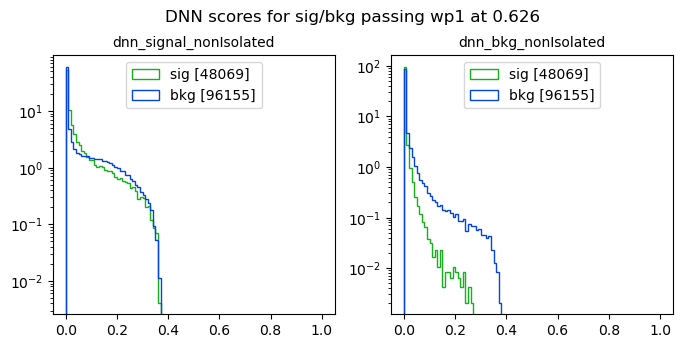

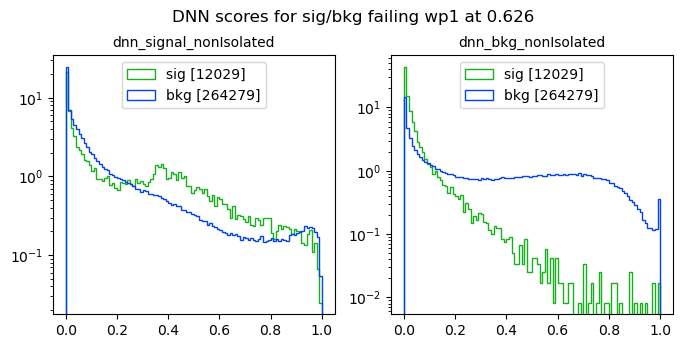

In [13]:
df_wp1pass = df[df['wp1']==True]
nsigwp1pass = df_wp1pass[df_wp1pass['truth']==1].shape[0]
nbkgwp1pass = df_wp1pass[df_wp1pass['truth']==0].shape[0]

df_wp1fail = df[df['wp1']==False]
nsigwp1fail = df_wp1fail[df_wp1fail['truth']==1].shape[0]
nbkgwp1fail = df_wp1fail[df_wp1fail['truth']==0].shape[0]

#Plotting:
bins_=np.arange(0, 1.01, 0.01)

fig6, ax6 = plt.subplots(1,2,figsize=(8,3.5))
ax6 = ax6.flatten()
fig6.subplots_adjust(hspace=0.5)
plt.subplots_adjust(top=0.85)
fig6.suptitle(f'DNN scores for sig/bkg passing wp1 at {wp1:.3f}', fontsize=12)

index=0
for score in ['score2', 'score3']:
    ax6[index].hist(df_wp1pass[df_wp1pass['truth']==1][score], bins=bins_, histtype='step',
                    color='xkcd:green', label=f'sig [{nsigwp1pass}]', density=True)
    ax6[index].hist(df_wp1pass[df_wp1pass['truth']==0][score], bins=bins_, histtype='step',
                    color='xkcd:blue',  label=f'bkg [{nbkgwp1pass}]', density=True)
    ax6[index].set_title(alias[score], fontsize=10)
    ax6[index].set_yscale('log')
    ax6[index].legend(loc='upper center')
    index = index+1

plt.savefig(f'plots/{campaign}/wp1_pass.png', bbox_inches='tight', dpi=300)
plt.show()

fig7, ax7 = plt.subplots(1,2,figsize=(8,3.5))
ax7 = ax7.flatten()
fig7.subplots_adjust(hspace=0.5)
plt.subplots_adjust(top=0.85)
fig7.suptitle(f'DNN scores for sig/bkg failing wp1 at {wp1:.3f}', fontsize=12)

index=0
for score in ['score2', 'score3']:
    ax7[index].hist(df_wp1fail[df_wp1fail['truth']==1][score], bins=bins_, histtype='step',
                    color='xkcd:green', label=f'sig [{nsigwp1fail}]', density=True)
    ax7[index].hist(df_wp1fail[df_wp1fail['truth']==0][score], bins=bins_, histtype='step',
                    color='xkcd:blue',  label=f'bkg [{nbkgwp1fail}]', density=True)
    ax7[index].set_title(alias[score], fontsize=10)
    ax7[index].set_yscale('log')
    ax7[index].legend(loc='upper center')
    index = index+1

plt.savefig(f'plots/{campaign}/wp1_fail.png', bbox_inches='tight', dpi=300)
plt.show()

### ROC curves for the other nodes after choosing wp1

In [14]:
from sklearn.metrics import roc_curve,auc

true_wp1pass = df_wp1pass['truth'] #Either 0, or 1
true_wp1fail = df_wp1fail['truth'] #Either 0, or 1

ROCdict_wp1pass ={
    "score2":{},
    "score3":{},
    "score4":{},
    "score5":{},
    "MVA1":{},
    "MVA2":{},
}

ROCdict_wp1fail = ROCdict_wp1pass

for score, scoredict in ROCdict_wp1pass.items():
    fnr, tpr, auc_score = find_tpr_fnr_auc(true_wp1pass, df_wp1pass[score])
    scoredict["fnr"] = fnr
    scoredict["tpr"] = tpr
    scoredict["auc"] = auc_score
    
for score, scoredict in ROCdict_wp1fail.items():
    fnr, tpr, auc_score = find_tpr_fnr_auc(true_wp1fail, df_wp1fail[score])
    scoredict["fnr"] = fnr
    scoredict["tpr"] = tpr
    scoredict["auc"] = auc_score

ROCdict_wp1pass = collections.OrderedDict(sorted(ROCdict_wp1pass.items(), key=lambda x: x[1]["auc"], reverse=True))
ROCdict_wp1fail = collections.OrderedDict(sorted(ROCdict_wp1fail.items(), key=lambda x: x[1]["auc"], reverse=True))

print('ROC dictionaries are ready.')

ROC dictionaries are ready.


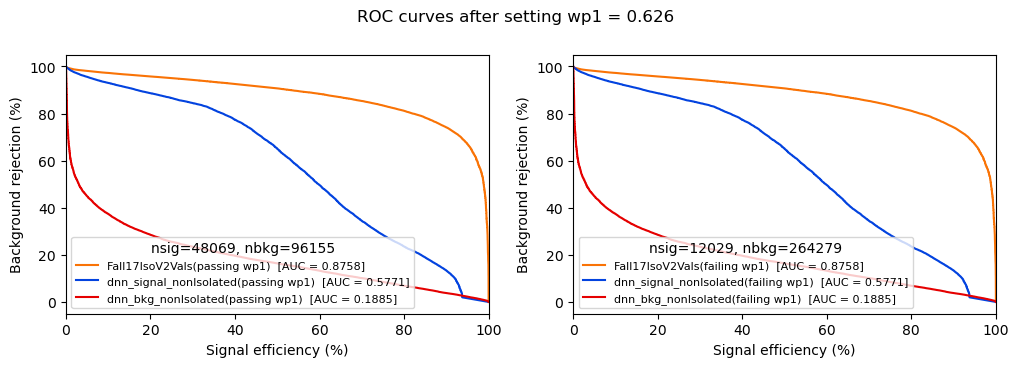

In [15]:
fig8, ax8 = plt.subplots(1,2,figsize=(12,3.5))
ax8 = ax8.flatten()
fig8.subplots_adjust(hspace=0.5)
plt.subplots_adjust(top=0.85)
fig8.suptitle(f'ROC curves after setting wp1 = {wp1:.3f}', fontsize=12)

#make plots for only the following:
plotdict={
    #'dnn_signal_Isolated':'xkcd:green',
    'dnn_signal_nonIsolated':'xkcd:blue',
    'dnn_bkg_nonIsolated':'xkcd:red',
    'Fall17IsoV2Vals':'xkcd:orange',
}

for score, scoredict in ROCdict_wp1pass.items():
    for plot, color_ in plotdict.items():
        if(plot == alias[score]):
            tpr = scoredict["tpr"]
            fnr = scoredict["fnr"]
            auc = scoredict["auc"]
            label_ = alias[score]+f'(passing wp1)  [AUC = {auc:.4f}]'
            ax8[0].plot(tpr,fnr,color=color_,label=label_)
            ax8[0].set_xlabel('Signal efficiency (%)')
            ax8[0].set_xlim(0, 100)
            #ax8[0].set_xscale('log')
            ax8[0].set_ylabel('Background rejection (%)')            
            legendheader = f'nsig={nsigwp1pass}, nbkg={nbkgwp1pass}'
            ax8[0].legend(loc='lower left', prop={"size":8}, title=legendheader, fontsize='small')
            
for score, scoredict in ROCdict_wp1fail.items():
    for plot, color_ in plotdict.items():
        if(plot == alias[score]):
            tpr = scoredict["tpr"]
            fnr = scoredict["fnr"]
            auc = scoredict["auc"]
            label_ = alias[score]+f'(failing wp1)  [AUC = {auc:.4f}]'
            ax8[1].plot(tpr,fnr,color=color_,label=label_)
            ax8[1].set_xlabel('Signal efficiency (%)')
            ax8[1].set_xlim(0, 100)
            #ax8[1].set_xscale('log')
            ax8[1].set_ylabel('Background rejection (%)')            
            legendheader = f'nsig={nsigwp1fail}, nbkg={nbkgwp1fail}'
            ax8[1].legend(loc='lower left', prop={"size":8}, title=legendheader, fontsize='small')

plt.savefig(f'plots/{campaign}/wp1_roc.png', bbox_inches='tight', dpi=300)
plt.show()